In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [10]:
import torch
import torch.nn as nn
import torchvision.models as models
from PIL import Image
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from torchvision import transforms

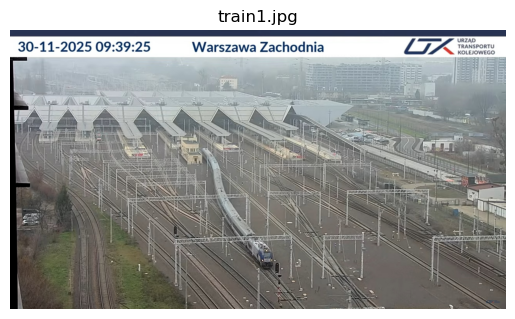

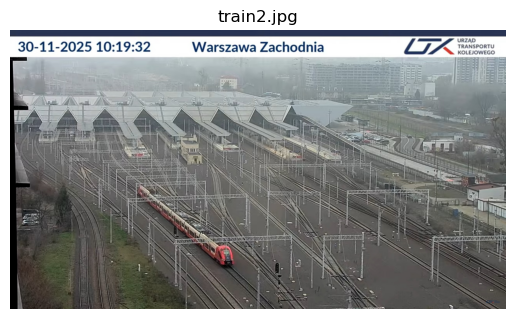

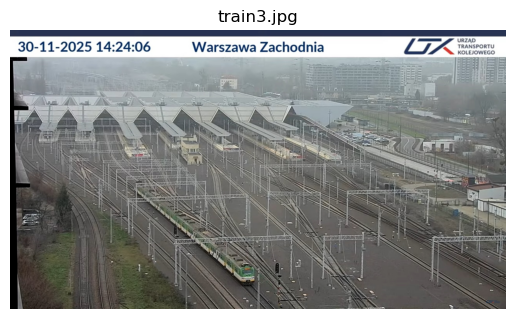

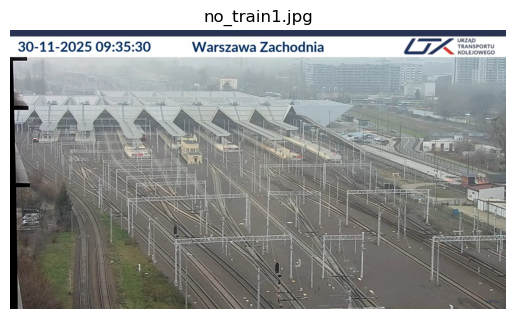

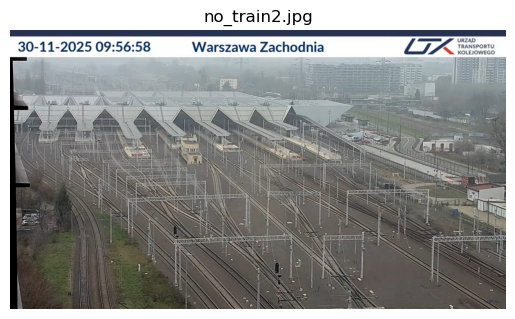

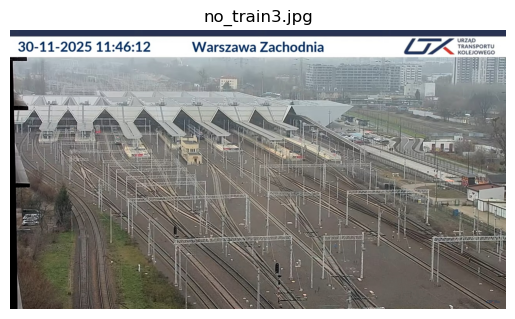

In [11]:
from PIL import Image
import matplotlib.pyplot as plt

path = ''

names = ['train1.jpg', 'train2.jpg', 'train3.jpg','no_train1.jpg', 'no_train2.jpg', 'no_train3.jpg']
images = []


for name in names:
    img = Image.open(path + name)
    images.append(img)

    plt.imshow(img)
    plt.title(name)
    plt.axis('off')
    plt.show()



In [12]:
from img2vec_pytorch import Img2Vec
import numpy as np
from sklearn.decomposition import PCA

def encode_and_do_pca(encoder,images):
  vectors = []

  for img in images:
      vec = encoder.get_vec(img)
      vectors.append(vec)

  vectors = np.vstack(vectors)
  print("Vector shape:", vectors.shape)
  pca = PCA(n_components=2)
  vectors_reduced = pca.fit_transform(vectors)

  vectors_reduced_tr = vectors_reduced[:3]
  vectors_reduced_no_tr = vectors_reduced[3:]
  plt.scatter(vectors_reduced_tr[:, 0], vectors_reduced_tr[:, 1], label='train')
  plt.scatter(vectors_reduced_no_tr[:, 0], vectors_reduced_no_tr[:, 1], label='no train')
  plt.legend()
  plt.title('PCA analysis')
  plt.show()

Vector shape: (6, 512)


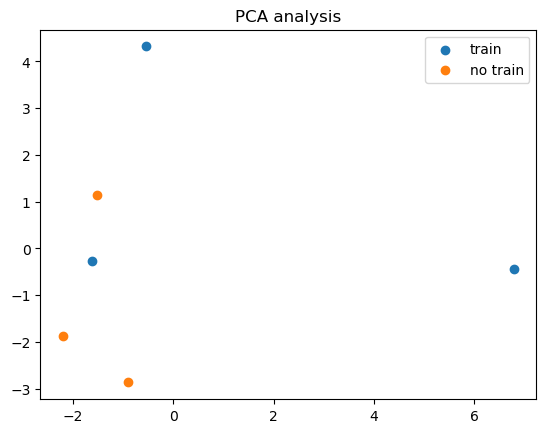

In [13]:
resnet18 = Img2Vec(model='resnet18',cuda=False)
encode_and_do_pca(resnet18,images)

Vector shape: (6, 2048)


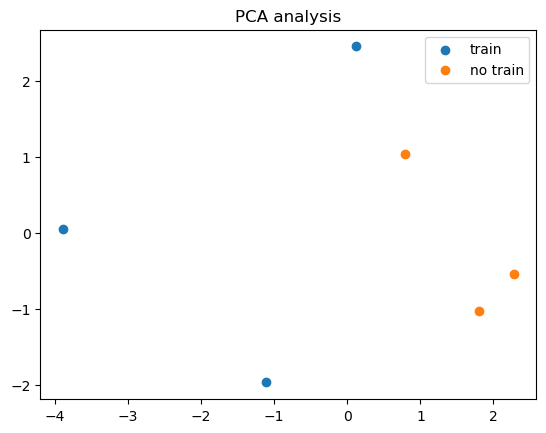

In [14]:
resnet152 = Img2Vec(model='resnet152',cuda=False)
encode_and_do_pca(resnet152,images)

Vector shape: (6, 4096)


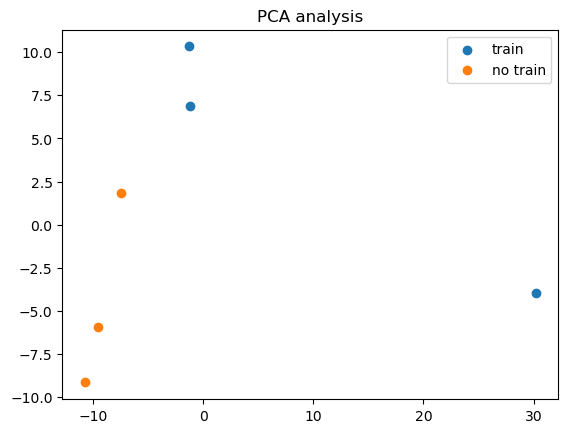

In [15]:
alexnet = Img2Vec(model='alexnet',cuda=False)
encode_and_do_pca(alexnet,images)

Vector shape: (6, 4096)


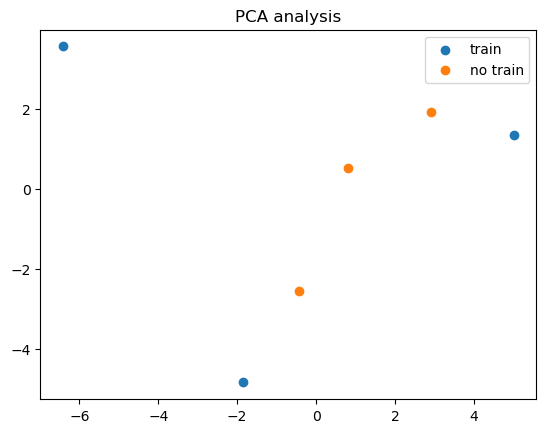

In [16]:
vgg19 = Img2Vec(model='vgg19',cuda=False)
encode_and_do_pca(vgg19,images)

Vector shape: (6, 1920)


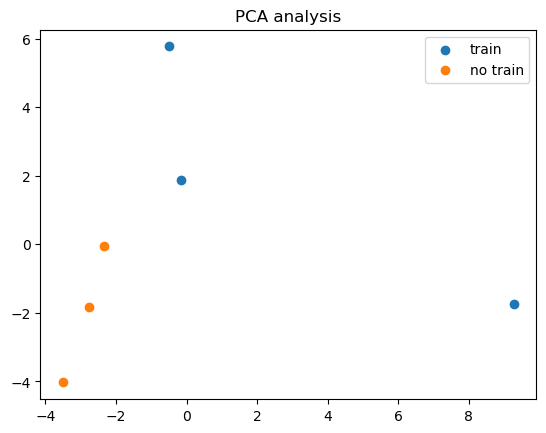

In [17]:
densenet201 = Img2Vec(model='densenet201',cuda=False)
encode_and_do_pca(densenet201,images)

Vector shape: (6, 2560)


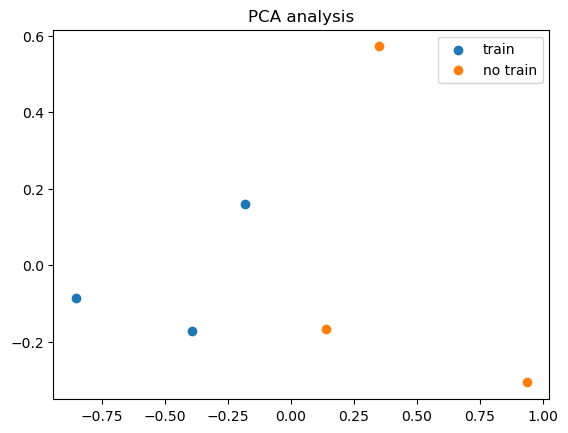

In [18]:
efficientnetb7 = Img2Vec(model='efficientnet_b7',cuda=False)
encode_and_do_pca(efficientnetb7,images)

In [19]:
import timm

In [20]:
class DinoExtractor:
    def __init__(self):
        self.model = timm.create_model('vit_small_patch16_224_dino', pretrained=True,)
        self.model.reset_classifier(0)
        self.model.eval()

    def get_vec(self, img):
        data_config = timm.data.resolve_model_data_config(self.model)
        transforms = timm.data.create_transform(**data_config, is_training=False)

        with torch.no_grad():
            features = self.model.forward_features(transforms(img).unsqueeze(0))
            output = self.model.forward_head(features, pre_logits=True)

        return output

C:\Users\micha\.conda\envs\projektUM\Lib\site-packages\timm\models\_factory.py:126: UserWarning: Mapping deprecated model name vit_small_patch16_224_dino to current vit_small_patch16_224.dino.
  model = create_fn(


Vector shape: (6, 384)


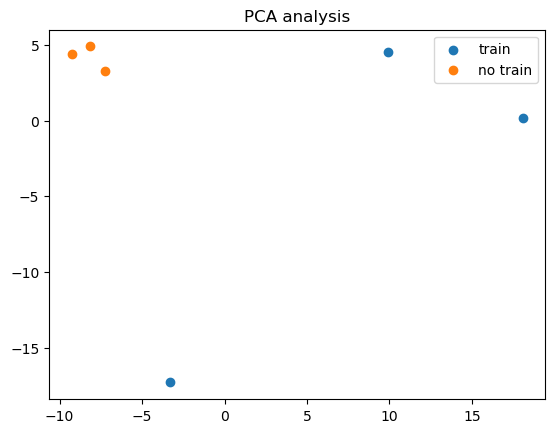

In [21]:
dino = DinoExtractor()
encode_and_do_pca(dino, images)

In [22]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [23]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3,32,3,stride=2,padding=1), nn.ReLU(),
            nn.Conv2d(32,64,3,stride=2,padding=1), nn.ReLU(),
            nn.Conv2d(64,128,3,stride=2,padding=1), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128*28*28, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim,128*28*28), nn.ReLU(),
            nn.Unflatten(1,(128,28,28)),
            nn.ConvTranspose2d(128,64,3,stride=2,padding=1,output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64,32,3,stride=2,padding=1,output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32,3,3,stride=2,padding=1,output_padding=1), nn.Sigmoid()
        )
    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out, z

In [24]:
class AutoencoderVec:
    def __init__(self, autoencoder, transform):
        self.model = autoencoder
        self.model.eval()
        self.transform = transform
        
    def get_vec(self, img: Image.Image):
        img_t = self.transform(img).unsqueeze(0)
        with torch.no_grad():
            _, z = self.model(img_t)
        return z.squeeze().numpy()

In [25]:
image_tensors = [transform(img) for img in images]
image_batch = torch.stack(image_tensors)

In [26]:
ae = Autoencoder(latent_dim=128)
optimizer = torch.optim.Adam(ae.parameters())
criterion = nn.MSELoss()

In [27]:
for epoch in range(20):
    optimizer.zero_grad()
    recon, _ = ae(image_batch)
    loss = criterion(recon, image_batch)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 0.0384
Epoch 2, Loss: 0.0384
Epoch 3, Loss: 0.0381
Epoch 4, Loss: 0.0379
Epoch 5, Loss: 0.0373
Epoch 6, Loss: 0.0363
Epoch 7, Loss: 0.0348
Epoch 8, Loss: 0.0324
Epoch 9, Loss: 0.0292
Epoch 10, Loss: 0.0265
Epoch 11, Loss: 0.0233
Epoch 12, Loss: 0.0207
Epoch 13, Loss: 0.0181
Epoch 14, Loss: 0.0160
Epoch 15, Loss: 0.0142
Epoch 16, Loss: 0.0129
Epoch 17, Loss: 0.0120
Epoch 18, Loss: 0.0112
Epoch 19, Loss: 0.0104
Epoch 20, Loss: 0.0097


Vector shape: (6, 128)


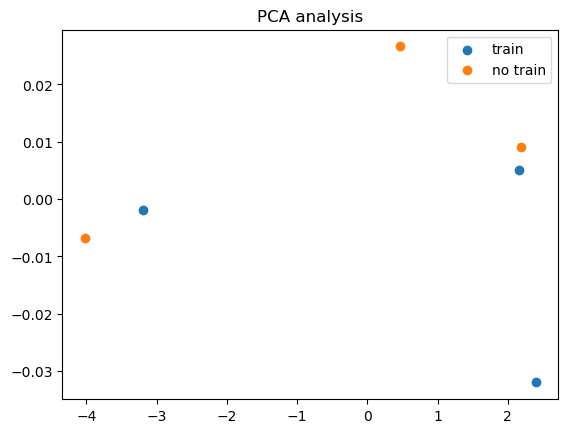

In [28]:
ae_encoder = AutoencoderVec(ae, transform)
encode_and_do_pca(ae_encoder, images)